In [ ]:
from google.colab import files

files.upload()

In [7]:
import pandas as pd
from datetime import datetime as dt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [4]:
def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}': lambda x: np.sin(2 * np.pi * (df[col_name] - start_num) / period),
        f'cos_{col_name}': lambda x: np.cos(2 * np.pi * (df[col_name] - start_num) / period)
    }
    return df.assign(**kwargs)

In [5]:
df = pd.read_csv('train.csv')
df = df[['time', 'temp', 'el_price', 'coco', 'consumption']].dropna()

df['hour'] = df['time'].apply(lambda x: dt.strptime(str(x), "%Y-%m-%d %H:%M:%S%z").hour)
df['month'] = df['time'].apply(lambda x: dt.strptime(str(x), "%Y-%m-%d %H:%M:%S%z").month)

df = generate_cyclical_features(df, 'hour', 24, 0)
df = generate_cyclical_features(df, 'month', 12, 1)

# Without cyclical features

In [16]:
features = ['temp', 'el_price', 'coco', 'hour', 'month']
X = df[features]
y = df['consumption']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, shuffle=False)
print(X_train.shape)
print(X_test.shape)

(8226, 5)
(168, 5)


In [18]:
params = {
    "n_estimators": 200,
    "max_depth": 3,
    "min_samples_split": 2,
    "learning_rate": 0.02,
    "loss": "squared_error",
}
model = GradientBoostingRegressor(**params)
model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.02, n_estimators=200)

0.2808994998807628


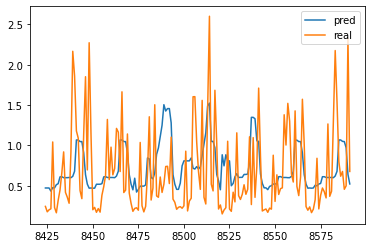

In [20]:
pred = model.predict(X_test)

mse = ((y_test - pred) ** 2).mean()
print(mse)

results = pd.DataFrame({'pred': pred, 'real': y_test})
results.plot()

# With cyclical features

In [24]:
features = ['temp', 'el_price', 'coco', 'cos_hour', 'cos_month']
X = df[features]
y = df['consumption']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, shuffle=False)
print(X_train.shape)
print(X_test.shape)

(8226, 5)
(168, 5)


In [26]:
params = {
    "n_estimators": 200,
    "max_depth": 3,
    "min_samples_split": 2,
    "learning_rate": 0.02,
    "loss": "squared_error",
}
model = GradientBoostingRegressor(**params)
model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.02, n_estimators=200)

0.28801747845635506


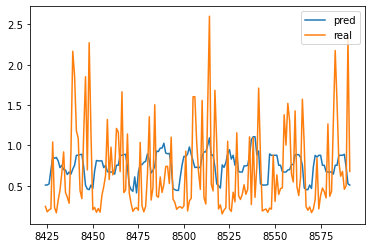

In [27]:
pred = model.predict(X_test)

mse = ((y_test - pred) ** 2).mean()
print(mse)

results = pd.DataFrame({'pred': pred, 'real': y_test})
results.plot()

# Trained on last 2 weeks

In [31]:
features = ['temp', 'el_price', 'coco', 'cos_hour', 'cos_month']
X = df[features].tail(504)
y = df['consumption'].tail(504)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.333, shuffle=False)
print(X_train.shape)
print(X_test.shape)

(336, 5)
(168, 5)


In [32]:
params = {
    "n_estimators": 200,
    "max_depth": 3,
    "min_samples_split": 2,
    "learning_rate": 0.02,
    "loss": "squared_error",
}
model = GradientBoostingRegressor(**params)
model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.02, n_estimators=200)

0.23760069719273585


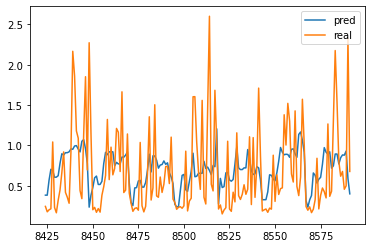

In [33]:
pred = model.predict(X_test)

mse = ((y_test - pred) ** 2).mean()
print(mse)

results = pd.DataFrame({'pred': pred, 'real': y_test})
results.plot()

# Submission

In [34]:
features = ['temp', 'el_price', 'coco', 'cos_hour', 'cos_month']
X = df[features].tail(336)
y = df['consumption'].tail(336)
params = {
    "n_estimators": 200,
    "max_depth": 3,
    "min_samples_split": 2,
    "learning_rate": 0.02,
    "loss": "squared_error",
}
model = GradientBoostingRegressor(**params)
model.fit(X, y)

test = pd.read_csv('test.csv')
test = test[['time', 'temp', 'el_price', 'coco']]

test['hour'] = test['time'].apply(lambda x: dt.strptime(str(x), "%Y-%m-%d %H:%M:%S%z").hour)
test['month'] = test['time'].apply(lambda x: dt.strptime(str(x), "%Y-%m-%d %H:%M:%S%z").month)

test = generate_cyclical_features(test, 'hour', 24, 0)
test = generate_cyclical_features(test, 'month', 12, 1)

predicitons = model.predict(test[features])

submissions = pd.DataFrame({'time': test['time'], 'consumption': predicitons})
submissions.to_csv('submissions_xgb_2.csv', index=False)